In [1]:
#set up sys
import os, sys
sys.path.append('../PMC_func')


#python basics
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import logging
from collections import Counter

#spacy stuff
import spacy
from spacy.language import Language
from spacy.tokens import Doc
from spacy.attrs import LOWER, POS, ENT_TYPE, IS_ALPHA, DEP, LEMMA, LOWER, IS_PUNCT, IS_DIGIT, IS_SPACE, IS_STOP
import en_core_web_sm

#gensim stuff
from gensim.models import CoherenceModel, LdaMulticore,LdaModel
from gensim.models.callbacks import ConvergenceMetric
from gensim.models.phrases import Phrases, ENGLISH_CONNECTOR_WORDS


# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis  # don't skip this

#custom dependencies
import PMC_module

#other
import pickle
import warnings
warnings.filterwarnings('ignore')

### Import Data
- Pickled Gensim Objects
- Composite Data Frame

In [2]:
nogram_filename = "../pickled_data/nogram_corpus.pkl"
bigram_filename = "../pickled_data/bigram_corpus.pkl"
trigram_filename = "../pickled_data/trigram_corpus.pkl"
df_lemmatized_texts = "../pickled_data/df_lemmatized_texts.pkl"

with open(nogram_filename, "rb") as f:
    nogram_list_lemmatized_texts, nogram_corpus, nogram_id2word = pickle.load(f)

with open(bigram_filename, "rb") as g:
    bigram_list_lemmatized_texts, bi_corpus, bi_id2word = pickle.load(g)
    
with open(trigram_filename, "rb") as h:
    trigram_list_lemmatized_texts, tri_corpus, tri_id2word = pickle.load(h)
    
with open(df_lemmatized_texts, "rb") as m:
    df_lemmatized_texts = pickle.load(m)

In [3]:
# store raw texts as a list for later
df_list = df_lemmatized_texts.text.tolist()

### Gensim LDA modeling - Hyper Parameter Tunning

#### Coherence Score

In [4]:
logging.basicConfig(filename='model_callbacks.log',
                    format="%(asctime)s:%(levelname)s:%(message)s",
                    level=logging.NOTSET)

convergence_logger = ConvergenceMetric(logger='shell')

In [5]:
num_topics_list = list(range(5,20,5))
model_lists = []
coherence_list = []

chunksize = 1000
passes = 4
iterations = 200
eval_every = 1
callbacks = [convergence_logger]

for num_topics in num_topics_list:
    lda_model = LdaModel(id2word=tri_id2word, 
                         num_topics=num_topics,
                         corpus=tri_corpus,
                         chunksize=chunksize,
                         alpha='auto',
                         eta='auto',
                         iterations=iterations,
                         passes=passes,
                         eval_every=eval_every,
                         callbacks= callbacks)
                             
    coherence_model_lda = CoherenceModel(model=lda_model, texts=trigram_list_lemmatized_texts, dictionary=tri_id2word, coherence='c_v')
    coherence_score = coherence_model_lda.get_coherence()
    model_lists.append(lda_model)
    coherence_list.append(coherence_score)
    print("LDA model/coherence complete for num_topics = ",num_topics, "; score = ", coherence_score)

LDA model/coherence complete for num_topics =  5 ; score =  0.4682852172522359
LDA model/coherence complete for num_topics =  10 ; score =  0.4316232168452741
LDA model/coherence complete for num_topics =  15 ; score =  0.37218793304563846


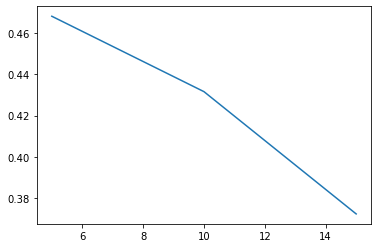

In [6]:
plt.plot(num_topics_list,coherence_list)

#### Topic Component Distribution - 5 topics

In [33]:
opt_topic_index = 0
topic_dict = {}
contribution_dict = {}
tuple_dict = {}

show_topics_output = model_lists[opt_topic_index].show_topics(num_topics=num_topics_list[opt_topic_index],formatted = False)
for i in range(len(show_topics_output)):
    row=show_topics_output[i]
    topic_dict["topic: "+str(i)] = [tuple[0] for tuple in row[1]]
    contribution_dict["topic: "+str(i)] = [tuple[1] for tuple in row[1]]    
    tuple_dict["topic: "+str(i)] = [tuple for tuple in row[1]]
    
contribution_df = pd.DataFrame(contribution_dict).T
topic_df = pd.DataFrame(topic_dict).T

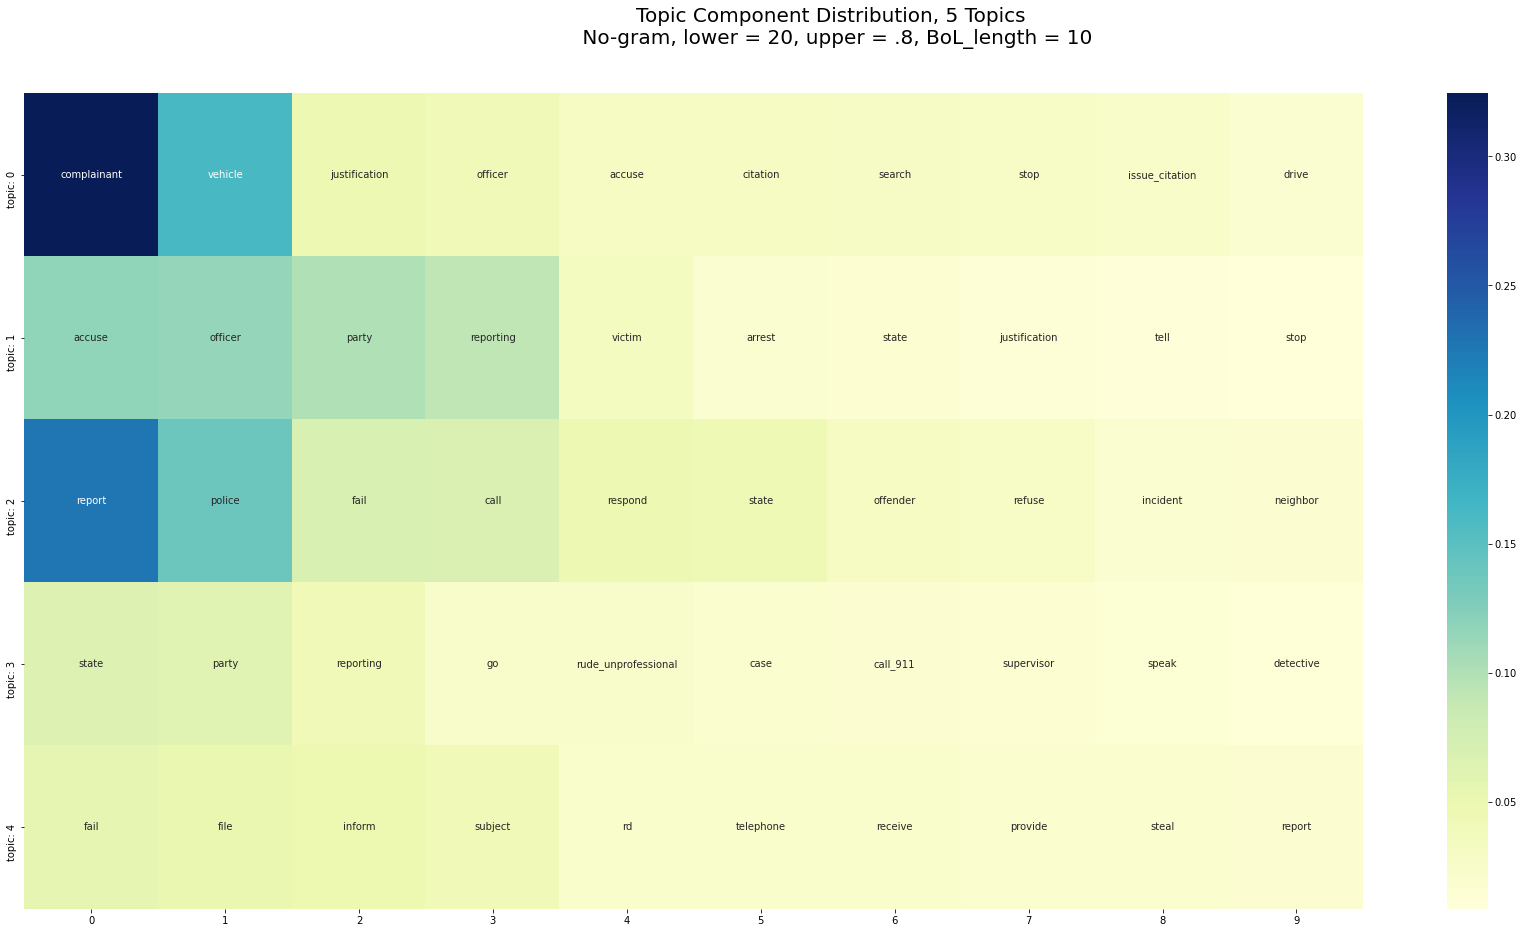

In [39]:
fig, ax = plt.subplots(1,1,figsize=(30,15))
ax = sns.heatmap(contribution_df, annot=topic_df,fmt = '', cmap="YlGnBu")
plt.suptitle("Topic Component Distribution, 5 Topics \n No-gram, lower = 20, upper = .8, BoL_length = 10", size = 20, y = .96)
plt.savefig('notebook_visualizations/topicdist_vis_combo_modeling_trigram_5topics1.png')

#### pyLDAvis Principal Component Visualization

In [9]:
# Visualize the topics
visualization_name = '../pyLDAvis/lda_vis_combo_trigram_5topics1.html'
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(model_lists[opt_topic_index], tri_corpus, tri_id2word)
pyLDAvis.save_html(vis, visualization_name)

/Users/pedrogalarza/anaconda3/envs/spacy_env/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pedrogalarza/anaconda3/envs/spacy_env/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pedrogalarza/anaconda3/envs/spacy_env/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pedrogalarza/anaconda3/envs/spacy_env/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Use

#### Most Represetative Documents


In [11]:
dom_topic_df_5 = PMC_module.find_dominiant_topics(model_lists[opt_topic_index],tri_corpus, trigram_list_lemmatized_texts,df_list)
top_representatives_5 = PMC_module.return_top_representatives(dom_topic_df_5, num_reps = 10)

In [46]:
top_representatives_5[top_representatives_5['Dominant_Topic'] == 0].head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,bag,input_documents
0,19426,0.0,0.5599,"[complainant, vehicle, justification, officer,...","[complainant, allege, pull, vehicle, unknown, ...",The complainant alleged that he was pulled\nov...
1,19427,0.0,0.5336,"[complainant, vehicle, justification, officer,...","[complainant, allege, pull, vehicle, unknown, ...",The complainant alleged that he was pulled\nov...
2,3527,0.0,0.5217,"[complainant, vehicle, justification, officer,...","[complainant, iy, allege, accuse, officer, sto...","The complainant, iy\nalleged that the accused ..."
3,12534,0.0,0.5146,"[complainant, vehicle, justification, officer,...","[complainant, allege, traffic_stop, accuse, of...",The complainants allege that during a traffic\...
4,998,0.0,0.5130,"[complainant, vehicle, justification, officer,...","[allege, traffic_stop, driver, unmarked, polic...",It is alleged during a traffic stop the driver...
5,997,0.0,0.5130,"[complainant, vehicle, justification, officer,...","[allege, traffic_stop, driver, unmarked, polic...",It is alleged during a traffic stop the driver...
6,25851,0.0,0.5095,"[complainant, vehicle, justification, officer,...","[complainant, allege, traffic_stop, accuse, of...",The complainant alleges that during the\ntraff...
7,3042,0.0,0.5041,"[complainant, vehicle, justification, officer,...","[complainant, allege, accuse, officer, release...",The complainants alleged the accused\nofficer ...
8,3041,0.0,0.5041,"[complainant, vehicle, justification, officer,...","[complainant, allege, accuse, officer, release...",The complainants alleged the accused\nofficer ...
9,8843,0.0,0.4836,"[complainant, vehicle, justification, officer,...","[complainant, allege, unknown_white_male, unif...",The complainant alleges that two\nunknown whit...


In [47]:
topic_of_interest = 0
print("Topic: {}".format(topic_of_interest))
print('---------')
for i in top_representatives_5[top_representatives_5['Dominant_Topic'] == topic_of_interest]['input_documents']:
    print(i)
    print('------')

Topic: 0
---------
The complainant alleged that he was pulled
over in his vehicle by two unknown civilian
dressed officer (one M/H and one M/W)
driving an unmarked vehicle bearing license
plate numbet he complainant
alleged that the officers searched him and
his vehicle without reason and after the
officers left the scene, the complainant
discovered that his Marquette Bank debit
card was missing from the center console
spot under his radio.
The complainant alleged that he was pulled
over in his vehicle by two unknown civilian
dressed officer (one M/H and one M/W)
driving an un hicle bearing license
plate numbet The complainant
alleged that the officers searched him and
his vehicle without reason and after the
officers left the scene, the complainant
discovered that his Marquette Bank debit
card was missing from the center console
spot under his radio.
The complainant alleged that he was pulled
over in his vehicle by two unknown civilian
dressed officer (one M/H and one M/W)
driving an 

#### Topic Component Distribution - 10 topics

In [41]:
opt_topic_index = 1
topic_dict = {}
contribution_dict = {}
tuple_dict = {}

show_topics_output = model_lists[opt_topic_index].show_topics(num_topics=num_topics_list[opt_topic_index],formatted = False)
for i in range(len(show_topics_output)):
    row=show_topics_output[i]
    topic_dict["topic: "+str(i)] = [tuple[0] for tuple in row[1]]
    contribution_dict["topic: "+str(i)] = [tuple[1] for tuple in row[1]]    
    tuple_dict["topic: "+str(i)] = [tuple for tuple in row[1]]
    
contribution_df = pd.DataFrame(contribution_dict).T
topic_df = pd.DataFrame(topic_dict).T

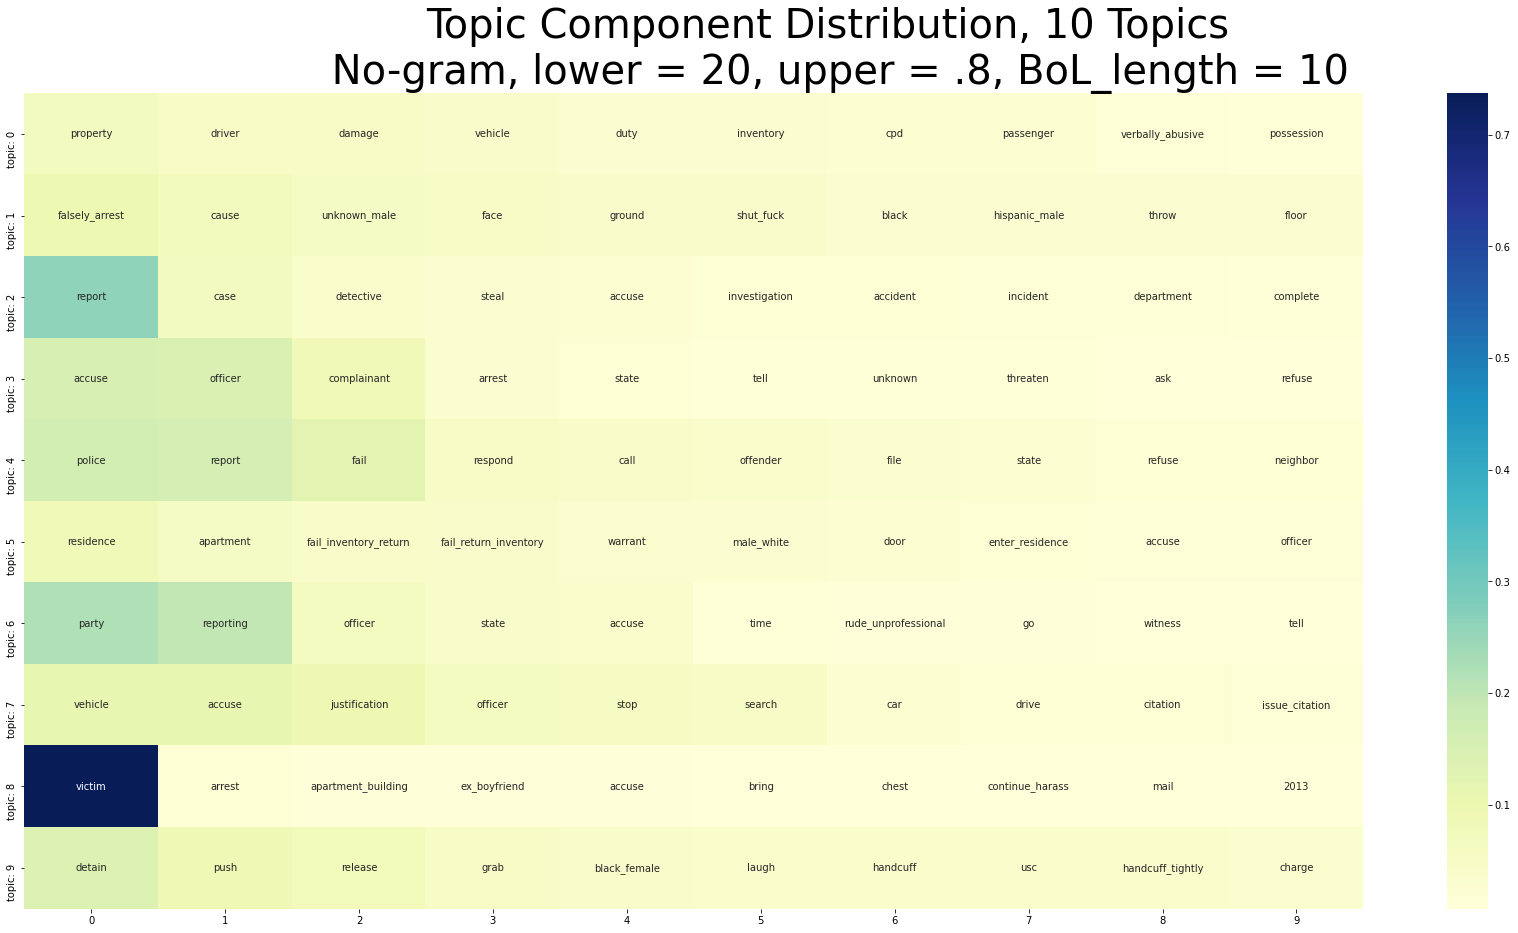

In [42]:
fig, ax = plt.subplots(1,1,figsize=(30,15))
ax = sns.heatmap(contribution_df, annot=topic_df,fmt = '', cmap="YlGnBu")
plt.suptitle("Topic Component Distribution, 10 Topics \n No-gram, lower = 20, upper = .8, BoL_length = 10", size = 40, y = .96)
plt.savefig('notebook_visualizations/topicdist_vis_combo_modeling_trigram_10topics1.png')

#### pyLDAvis Principal Component Visualization

In [21]:
# Visualize the topics
visualization_name = '../pyLDAvis/lda_vis_combo_trigram_10topics1.html'
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(model_lists[opt_topic_index], tri_corpus, tri_id2word)
pyLDAvis.save_html(vis, visualization_name)

#### Most Represetative Documents


In [23]:
dom_topic_df_10 = PMC_module.find_dominiant_topics(model_lists[opt_topic_index],tri_corpus, trigram_list_lemmatized_texts,df_list)
top_representatives_10 = PMC_module.return_top_representatives(dom_topic_df_10, num_reps = 10)

In [48]:
top_representatives_10[top_representatives_10['Dominant_Topic'] == 7].head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,bag,input_documents
66,10426,7.0,0.6114,"[vehicle, accuse, justification, officer, stop...","[reporting, party, allege, accuse, officer, st...",THE REPORTING PARTY ALLEGES THAT\nTHE ACCUSED ...
67,28642,7.0,0.5438,"[vehicle, accuse, justification, officer, stop...","[reporting, party, allege, accuse, officer, st...",THE REPORTING PARTY ALLEGES THAT\nTHE ACCUSED ...
68,28641,7.0,0.5438,"[vehicle, accuse, justification, officer, stop...","[reporting, party, allege, accuse, officer, st...",THE REPORTING PARTY ALLEGES THAT\nTHE ACCUSED ...
69,4907,7.0,0.5408,"[vehicle, accuse, justification, officer, stop...","[allege, durina, traffic_stop, accuse, exit_ve...","It is alleged that durina a traffic stop, the\..."
70,31550,7.0,0.5321,"[vehicle, accuse, justification, officer, stop...","[reporting, party, allege, accuse, stop, searc...",The reporting party alleged that the accused\n...
71,31551,7.0,0.5321,"[vehicle, accuse, justification, officer, stop...","[reporting, party, allege, accuse, stop, searc...",The reporting party alleged that the accused\n...
72,7693,7.0,0.5275,"[vehicle, accuse, justification, officer, stop...","[reporting, party, allege, traffic_stop, accus...",THE REPORTING PARTY ALLEGES THAT\nDURING A TRA...
73,25851,7.0,0.5270,"[vehicle, accuse, justification, officer, stop...","[complainant, allege, traffic_stop, accuse, of...",The complainant alleges that during the\ntraff...
74,12468,7.0,0.5254,"[vehicle, accuse, justification, officer, stop...","[reporting, party, allege, accuse, officer, st...",THE REPORTING PARTY ALLEGES THAT\nTHE ACCUSED ...
75,5101,7.0,0.5247,"[vehicle, accuse, justification, officer, stop...","[reporting, party, relay, arrest, accuse, traf...",The reporting party relays she was arrested\nb...


In [49]:
topic_of_interest = 7
print("Topic: {}".format(topic_of_interest))
print('---------')
for i in top_representatives_10[top_representatives_10['Dominant_Topic'] == topic_of_interest]['input_documents']:
    print(i)
    print('------')

Topic: 7
---------
THE REPORTING PARTY ALLEGES THAT
THE ACCUSED OFFICER STOPPED THE
VICTIM, PULLED HIM FROM HIS.
VEHICLE AND SEARCHED HIS VEHICLE
WITHOUT JUSTIFICATION.
THE REPORTING PARTY ALLEGES THAT
THE ACCUSED OFFICER STOPPED THE
VICTIM, PULLED HIM FROM HIS
VEHICLE AND SEARCHED HIS VEHICLE
WITHOUT JUSTIFICATION.
THE REPORTING PARTY ALLEGES THAT
THE ACCUSED OFFICER STOPPED THE
VICTIM, PULLED HIM FROM HIS
VEHICLE AND SEARCHED HIS VEHICLE
WITHOUT JUSTIFICATION.
THE REPORTING PARTY ALLEGES THAT
THE ACCUSED OFFICER STOPPED THE
VICTIM, PULLED HIM FROM HIS
VEHICLE AND SEARCHED HIS VEHICLE
WITHOUT JUSTIFICATION.
THE REPORTING PARTY ALLEGES THAT
THE ACCUSED OFFICER STOPPED THE
VICTIM, PULLED HIM FROM HIS
VEHICLE AND SEARCHED HIS VEHICLE
WITHOUT JUSTIFICATION.
------
THE REPORTING PARTY ALLEGES THAT
THE ACCUSED OFFICER STOPPED HIM,
ISSUED HIM THREE CITATIONS AND
PLACED A TOW TICKET ON HIS
VEHICLE WITHOUT JUSTIFICATION
MISSING FRONT/REAR PLATES
NQ DISPLAY CITY STICKER:
EXPIRED OR TEMPORARY PL

#### Topic Component Distribution - 15 topics

In [50]:
opt_topic_index = 2
topic_dict = {}
contribution_dict = {}
tuple_dict = {}

show_topics_output = model_lists[opt_topic_index].show_topics(num_topics=num_topics_list[opt_topic_index],formatted = False)
for i in range(len(show_topics_output)):
    row=show_topics_output[i]
    topic_dict["topic: "+str(i)] = [tuple[0] for tuple in row[1]]
    contribution_dict["topic: "+str(i)] = [tuple[1] for tuple in row[1]]    
    tuple_dict["topic: "+str(i)] = [tuple for tuple in row[1]]
    
contribution_df = pd.DataFrame(contribution_dict).T
topic_df = pd.DataFrame(topic_dict).T

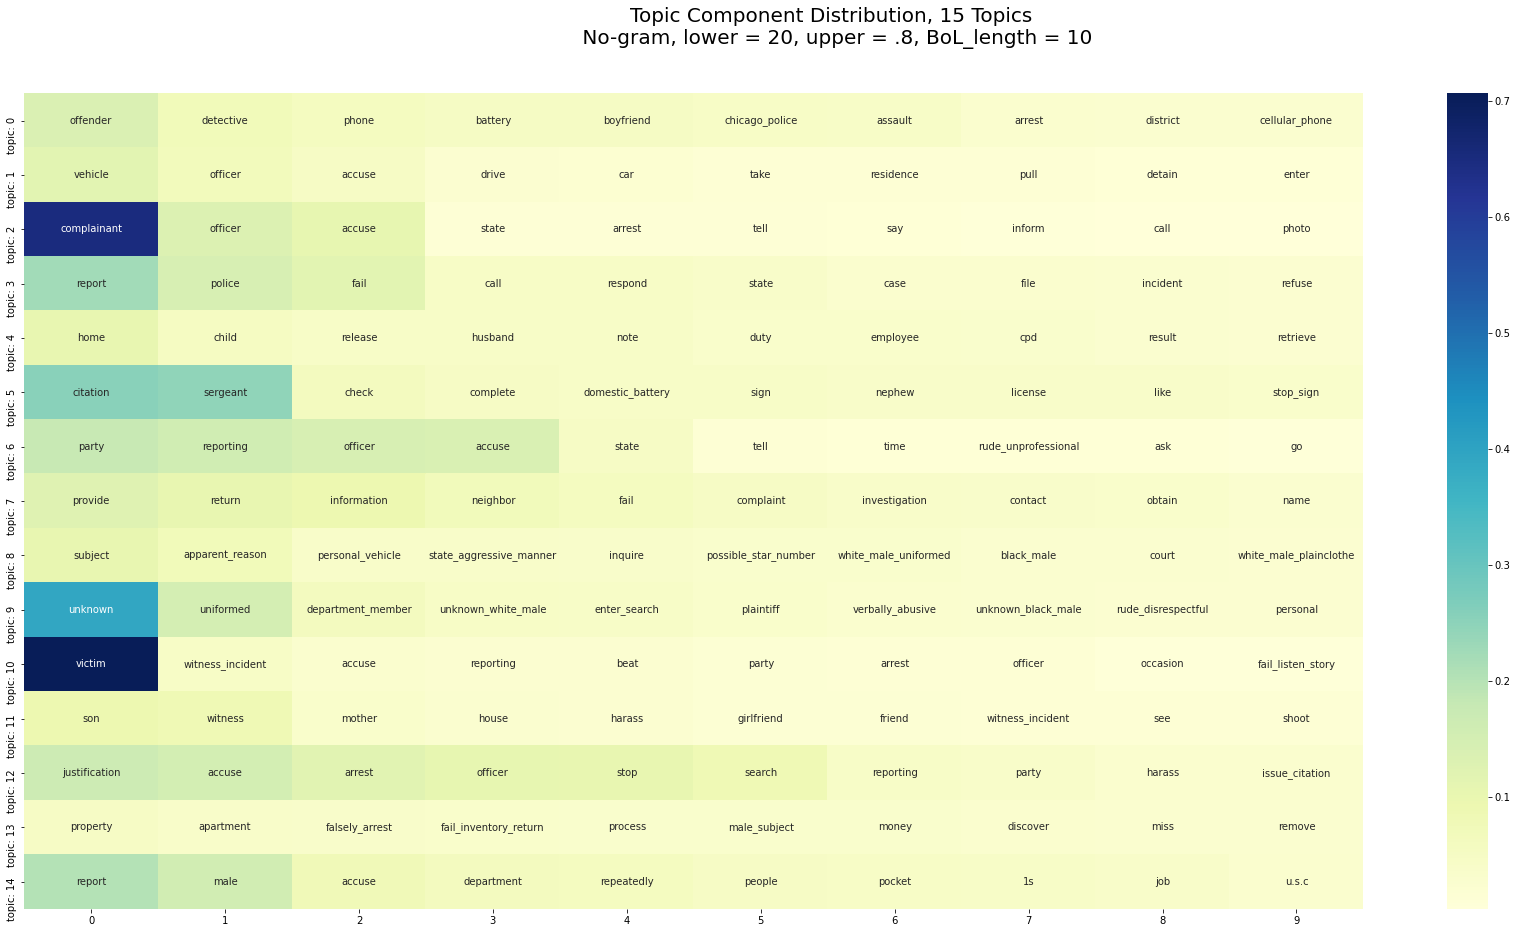

In [51]:
fig, ax = plt.subplots(1,1,figsize=(30,15))
ax = sns.heatmap(contribution_df, annot=topic_df,fmt = '', cmap="YlGnBu")
plt.suptitle("Topic Component Distribution, 15 Topics \n No-gram, lower = 20, upper = .8, BoL_length = 10", size = 20, y = .96)
plt.savefig('notebook_visualizations/topicdist_vis_combo_modeling_trigram_15topics1.png')

#### pyLDAvis Principal Component Visualization

In [28]:
# Visualize the topics
visualization_name = '../pyLDAvis/lda_vis_combo_trigram_15topics1.html'
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(model_lists[opt_topic_index], tri_corpus, tri_id2word)
pyLDAvis.save_html(vis, visualization_name)

/Users/pedrogalarza/anaconda3/envs/spacy_env/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pedrogalarza/anaconda3/envs/spacy_env/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pedrogalarza/anaconda3/envs/spacy_env/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pedrogalarza/anaconda3/envs/spacy_env/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


#### Most Represetative Documents


In [29]:
dom_topic_df_15 = PMC_module.find_dominiant_topics(model_lists[opt_topic_index],tri_corpus, trigram_list_lemmatized_texts,df_list)
top_representatives_15 = PMC_module.return_top_representatives(dom_topic_df_15, num_reps = 10)

In [52]:
top_representatives_15[top_representatives_15['Dominant_Topic'] == 1].head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,bag,input_documents
10,10288,1.0,0.6185,"[vehicle, officer, accuse, drive, car, take, r...","[victim, allege, involve_ina_toad_rage, incide...",Victims alleges that they were involved ina\nt...
11,7708,1.0,0.6057,"[vehicle, officer, accuse, drive, car, take, r...","[friend, nfi, drive, car, accuse, attempt, pul...","and her friend, _\n(NFI), were driving in car ..."
12,10286,1.0,0.5823,"[vehicle, officer, accuse, drive, car, take, r...","[victim, allege, involve_ina_toad_rage, incide...",Victims alleges that they were involved ina\nt...
13,4588,1.0,0.5633,"[vehicle, officer, accuse, drive, car, take, r...","[drive, reckless, 3rd, 4th, vehicle, stop, red...",was driving reckless in that the\nwas the 3rd ...
14,11515,1.0,0.5519,"[vehicle, officer, accuse, drive, car, take, r...","[allege, accuse, officer, unprofessional, pull...",alleged that the accused officers\nwere unprof...
15,10806,1.0,0.5509,"[vehicle, officer, accuse, drive, car, take, r...","[victim, allege, detention, unlawfully, delay,...",Victim alleges that his detention was\nunlawfu...
16,16189,1.0,0.5421,"[vehicle, officer, accuse, drive, car, take, r...","[mr, ittempte, drive, alley, residence, accuse...",Mr. __ittempted to drive through\nthe alley to...
17,18678,1.0,0.5409,"[vehicle, officer, accuse, drive, car, take, r...","[report, accuse, officer, pursue, strong_armed...","It is reported that the accused officer,\nwhil..."
18,22,1.0,0.5323,"[vehicle, officer, accuse, drive, car, take, r...","[report, accuse, male_hispanic, officer, enter...","It is reported that the accused, a male\nHispa..."
19,10155,1.0,0.5319,"[vehicle, officer, accuse, drive, car, take, r...","[complainant, allege, accuse, grab_push, hand,...",The complainant alleged that the accused\ngrab...


In [53]:
topic_of_interest = 1
print("Topic: {}".format(topic_of_interest))
print('---------')
for i in top_representatives_15[top_representatives_15['Dominant_Topic'] == topic_of_interest]['input_documents']:
    print(i)
    print('------')

Topic: 1
---------
Victims alleges that they were involved ina
toad rage incident in which he accidentally
cut-off a Police Officer's vehicle. When the
off-duty officer exited his vehicle he reached
in the interior of his car and grabbed an
object and began moving toward the
and his passenger exited
their vehicle and grabbed a softball bat from
their vehicle and re-entered the vehicle
when the light turned green and fled. Early
the next morning officers arrived and falsely
arrested him for aggravated assault.
Victims alleges that they were involved ina
toad rage incident in which he accidentally
cut-off a Police Officer's vehicle. When the
off-duty officer exited his vehicle he reached
in the interior of his car and grabbed an
object and began moving toward the
and his passenger exited
their vehicle and grabbed a softball bat from
their vehicle and re-entered the vehicle
when the light turned green and fled. Early
the next morning officers arrived and falsely
arrested him for aggravate